In [1]:
from skimage import color, io, measure, img_as_ubyte, util, data, morphology
from skimage.measure import profile_line
from skimage.transform import rescale, resize, rotate, matrix_transform, SimilarityTransform, EuclideanTransform, warp, swirl
import matplotlib.pyplot as plt
import numpy as np
import pydicom as dicom
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn import decomposition
from sklearn.decomposition import PCA
from skimage.util import img_as_float, img_as_ubyte
from skimage.color import rgb2gray, gray2rgb, rgb2hsv, label2rgb
from skimage.filters import threshold_otsu, prewitt_h, prewitt_v, prewitt
from skimage.morphology import erosion, dilation, opening, closing, disk, binary_closing, binary_opening
from skimage.segmentation import clear_border
from scipy.stats import norm
from scipy.spatial import distance
import scipy.io as sio
import glob
import os
import SimpleITK as sitk
from IPython.display import clear_output


1

In [7]:


# Step 1: Load DICOM file and annotation images
dicom_file_path = 'data/Abdominal/1-166.dcm'
dicom_image = dicom.dcmread(dicom_file_path).pixel_array

liver_annotation_path = 'data/Abdominal/LiverROI.png'
kidney_l_annotation_path = 'data/Abdominal/KidneyRoi_l.png'
kidney_r_annotation_path = 'data/Abdominal/KidneyRoi_r.png'

liver_mask = io.imread(liver_annotation_path) > 0
kidney_l_mask = io.imread(kidney_l_annotation_path) > 0
kidney_r_mask = io.imread(kidney_r_annotation_path) > 0

# Step 2: Apply masks to extract ROI pixel values
liver_pixels = dicom_image[liver_mask]
kidney_l_pixels = dicom_image[kidney_l_mask]
kidney_r_pixels = dicom_image[kidney_r_mask]

# Step 3: Compute the average Hounsfield units for each ROI
average_hu_liver = np.mean(liver_pixels)
average_hu_kidney_l = np.mean(kidney_l_pixels)
average_hu_kidney_r = np.mean(kidney_r_pixels)

# Print the results
print(f'Average HU for liver: {average_hu_liver}')
print(f'Average HU for left kidney: {average_hu_kidney_l}')
print(f'Average HU for right kidney: {average_hu_kidney_r}')

Average HU for liver: 76.33393774554246
Average HU for left kidney: 107.45075421472937
Average HU for right kidney: 107.56182572614108


2

In [19]:
liver_mask = io.imread(liver_annotation_path) > 0
kidney_l_mask = io.imread(kidney_l_annotation_path) > 0
kidney_r_mask = io.imread(kidney_r_annotation_path) > 0

# Step 2: Extract pixel values using the annotations
liver_pixels = dicom_image[liver_mask]
kidney_l_pixels = dicom_image[kidney_l_mask]
kidney_r_pixels = dicom_image[kidney_r_mask]

# Step 3: Compute the average Hounsfield unit (HU) values
average_hu_kidney_l = np.mean(kidney_l_pixels)
average_hu_kidney_r = np.mean(kidney_r_pixels)
print(f'Average HU for left kidney: {average_hu_kidney_l}')
print(f'Average HU for right kidney: {average_hu_kidney_r}')

# Step 4: Compute average and standard deviation of HU in the liver
average_hu_liver = np.mean(liver_pixels)
std_dev_hu_liver = np.std(liver_pixels)
print(f'Average HU for liver: {average_hu_liver}, Std Dev: {std_dev_hu_liver}')

# Step 5 & 6: Compute thresholds for liver segmentation
t_1 = average_hu_liver - std_dev_hu_liver
t_2 = average_hu_liver + std_dev_hu_liver

# Step 7: Create a binary image
binary_liver_image = np.zeros_like(dicom_image)
binary_liver_image[(dicom_image >= t_1) & (dicom_image <= t_2)] = 1

# Step 8-10: Morphological operations
disk3 = morphology.disk(3)
disk10 = morphology.disk(10)
binary_liver_image = morphology.binary_dilation(binary_liver_image, disk3)
binary_liver_image = morphology.binary_erosion(binary_liver_image, disk10)
binary_liver_image = morphology.binary_dilation(binary_liver_image, disk10)

# Step 11: Extract all BLOBs
label_image = measure.label(binary_liver_image)
regions = measure.regionprops(label_image)

# Step 12 & 13: Compute area and perimeter, and filter BLOBs
valid_regions = [region for region in regions if 1500 <= region.area <= 7000 and region.perimeter >= 300]
filtered_image = np.zeros_like(dicom_image, dtype=bool)
for region in valid_regions:
    for coords in region.coords:
        filtered_image[coords[0], coords[1]] = 1

# Step 14: Compute the DICE score
dice_score = 1 - distance.dice(liver_mask.ravel(), filtered_image.ravel())
print(f"DICE score: {dice_score}")

Average HU for left kidney: 107.45075421472937
Average HU for right kidney: 107.56182572614108
Average HU for liver: 76.33393774554246, Std Dev: 24.53705543438126
DICE score: 0.782588123964987


3

In [20]:
# Extract liver pixel values using the mask
liver_pixels = dicom_image[liver_mask]

# Compute the average and standard deviation of Hounsfield units for the liver
average_hu_liver = np.mean(liver_pixels)
std_dev_hu_liver = np.std(liver_pixels)

# Compute thresholds
t_1 = average_hu_liver - std_dev_hu_liver
t_2 = average_hu_liver + std_dev_hu_liver

# Create a binary image
binary_liver_image = np.zeros_like(dicom_image)
binary_liver_image[(dicom_image >= t_1) & (dicom_image <= t_2)] = 1

# Print the results
print(f'Average HU for liver: {average_hu_liver:.2f}')
print(f'Standard Deviation for liver HU: {std_dev_hu_liver:.2f}')
print(f'Threshold t_1 (Average - Std Dev): {t_1:.2f}')
print(f'Threshold t_2 (Average + Std Dev): {t_2:.2f}')

Average HU for liver: 76.33
Standard Deviation for liver HU: 24.54
Threshold t_1 (Average - Std Dev): 51.80
Threshold t_2 (Average + Std Dev): 100.87


4

In [28]:
from sklearn.preprocessing import MinMaxScaler
glass_data = np.loadtxt('data/GlassPCA/glass_data.txt', comments='%') 
# Assuming glass_data is your dataset loaded as a NumPy array
scaler = MinMaxScaler()
glass_scaled = scaler.fit_transform(glass_data)

# Initialize PCA
pca = PCA()

# Fit PCA on the scaled data
pca.fit(glass_scaled)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Compute the total variation explained by the first three components
total_variation_first_three = explained_variance_ratio[:3].sum()
total_variation_first_three

First value of Sodium after subtraction of the mean and scaling: [0.43283582 0.43759398 1.         0.25233645 0.35178571 0.00966184
 0.30855019 0.         0.        ]


0.7606912558548663

5

In [26]:
# Compute the covariance matrix of the scaled data
covariance_matrix = np.cov(glass_scaled.T)  # Transpose to make variables along columns

# Extract the value at position (0, 0) which is the variance of the first feature
variance_first_feature = covariance_matrix[0, 0]

print(f"The variance of the first feature (position (0, 0) of the covariance matrix) is: {variance_first_feature}")

The variance of the first feature (position (0, 0) of the covariance matrix) is: 0.01777228105379087


6

In [29]:
glass_data = np.loadtxt('data/GlassPCA/glass_data.txt', comments='%')

# Step 1: Subtract the mean from each column
mn = np.mean(glass_data, axis=0)
data_centered = glass_data - mn

# Step 2: Compute the minimum and maximum values for each measurement
min_val = np.min(data_centered, axis=0)
max_val = np.max(data_centered, axis=0)

# Compute the range (max-min) for each feature
range_val = max_val - min_val

# Step 3: Divide each measurement by the difference between the max and min
data_scaled = data_centered / range_val

# Extract the first value of the Sodium (Na) measurements after subtraction of the mean and scaling
first_value_na = data_scaled[0, 1]  # Assuming Sodium (Na) is the second column in the dataset

print(f"The first value of the Sodium (Na) measurements after mean subtraction and scaling is: {first_value_na}")

The first value of the Sodium (Na) measurements after mean subtraction and scaling is: 0.034909704166959016


7

In [30]:
# Initialize PCA
pca = PCA()

# Fit PCA on the scaled data
pca.fit(data_scaled)

# Project the scaled data onto the principal components
data_projected = pca.transform(data_scaled)

# Compute the absolute values of the projected data
data_projected_abs = np.abs(data_projected)

# Find the maximum absolute value from the projected data
max_absolute_value = np.max(data_projected_abs)

print(f"The maximum absolute value from the projected data is: {max_absolute_value}")

The maximum absolute value from the projected data is: 1.1211053359943697


8

In [32]:
def rotation_matrix(pitch, roll, yaw):
    pitch = np.deg2rad(pitch)
    roll = np.deg2rad(roll)
    yaw = np.deg2rad(yaw)

    Rx = np.array([
        [1, 0, 0, 0],
        [0, np.cos(pitch), -np.sin(pitch), 0],
        [0, np.sin(pitch), np.cos(pitch), 0],
        [0, 0, 0, 1]
    ])

    Ry = np.array([
        [np.cos(roll), 0, np.sin(roll), 0],
        [0, 1, 0, 0],
        [-np.sin(roll), 0, np.cos(roll), 0],
        [0, 0, 0, 1]
    ])

    Rz = np.array([
        [np.cos(yaw), -np.sin(yaw), 0, 0],
        [np.sin(yaw), np.cos(yaw), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

    return np.dot(np.dot(Rx, Ry), Rz)

# Create rotation for 30 degrees roll and 10 degrees yaw
R_roll = rotation_matrix(0, 30, 0)
R_yaw = rotation_matrix(0, 0, 10)

# Translation matrix
T = np.array([
    [1, 0, 0, 10],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

# Combine transformations
combined_transform = np.dot(T, np.dot(R_yaw, R_roll))

print("Combined Affine Transformation Matrix:\n", combined_transform)

Combined Affine Transformation Matrix:
 [[ 0.85286853 -0.17364818  0.49240388 10.        ]
 [ 0.15038373  0.98480775  0.08682409  0.        ]
 [-0.5         0.          0.8660254   0.        ]
 [ 0.          0.          0.          1.        ]]


9

In [35]:
def process_image(image_path):
    # Step 1: Load the image and convert it from RGB to HSV
    rgb_image = io.imread(image_path)
    hsv_image = color.rgb2hsv(rgb_image)
    
    # Step 2: Create an image that only contains the H component
    h_image = hsv_image[:, :, 0]
    
    # Step 3: Create a binary image by thresholding the H component
    binary_image = np.zeros(h_image.shape, dtype=np.uint8)
    binary_image[(h_image > 0.3) & (h_image < 0.7)] = 1
    
    # Step 4: Perform a morphological dilation
    struct_elem = morphology.disk(8)
    dilated_image = morphology.binary_dilation(binary_image, struct_elem)
    
    num_foreground_pixels = np.sum(dilated_image == 1)

    return rgb_image, h_image, binary_image, dilated_image, num_foreground_pixels

# Load and process the imageExams/Exam_Spring_2023
image_path = 'data/nike.png'  # Update this to your image path
rgb_image, h_image, binary_image, dilated_image, num_foreground_pixels = process_image(image_path)

print(f"Number of foreground pixels in the dilated image: {num_foreground_pixels}")





Number of foreground pixels in the dilated image: 58979


10

In [45]:
shoe_1 = io.imread('data/LMRegistration/shoe_1.png')  # Replace with the path to shoe_1Exams/Exam_Spring_2023/data/LMRegistration/shoe_1.png
shoe_2 = io.imread('data/LMRegistration/shoe_2.png')  # Replace with the path to shoe_2

# Define landmarks manually placed on both images
src = np.array([[40, 320], [425, 120], [740, 330]])  # Landmarks on shoe_1
dst = np.array([[80, 320], [380, 155], [670, 300]])  # Landmarks on shoe_2

tform = SimilarityTransform()
tform.estimate(src, dst)

aligned_shoe_1 = warp(shoe_1, inverse_map=tform.inverse, output_shape=shoe_2.shape)
aligned_shoe_2 = warp(shoe_2, inverse_map=tform.inverse, output_shape=shoe_1.shape)

# Convert both images to ubyte format
shoe_1_ubyte = img_as_ubyte(aligned_shoe_1)
shoe_2_ubyte = img_as_ubyte(aligned_shoe_2)

# Extract the blue component at position (200, 200)
blue_shoe_1 = shoe_1_ubyte[200, 200, 2]
blue_shoe_2 = shoe_2_ubyte[200, 200, 2]

# Calculate the absolute difference
absolute_difference = np.abs(blue_shoe_1 - blue_shoe_2)

print(f"Absolute difference in blue components at (200, 200): {absolute_difference}")


Absolute difference in blue components at (200, 200): 26


In [43]:
# Example landmarks on shoe_1 (source) and shoe_2 (destination)
src = np.array([[40, 320], [425, 120], [740, 330]])  # Source landmarks
dst = np.array([[80, 320], [380, 155], [670, 300]])  # Destination landmarks

# Create and estimate the similarity transform
tform = SimilarityTransform()
tform.estimate(src, dst)

# After the transformation has been estimated, access the scale
scale_of_transformation = tform.scale

print(f"Scale of the transformation: {scale_of_transformation}")

Scale of the transformation: 0.8327055808649095


11

In [ ]:
# Define the landmarks for source (shoe_1) and destination (shoe_2) images
src = np.array([[40, 320], [425, 120], [740, 330]])  # Source landmarks
dst = np.array([[80, 320], [380, 155], [670, 300]])  # Destination landmarks

# Create and estimate the similarity transform
tform = SimilarityTransform()
tform.estimate(src, dst)

# Function to calculate sum of squared distances between landmarks
def calculate_F(src, dst):
    return np.sum((src - dst) ** 2)

# Calculate initial alignment error
initial_error = calculate_F(src, dst)

# Apply the transformation to the source landmarks
transformed_src = tform(src)

# Calculate alignment error after the transformation
final_error = calculate_F(transformed_src, dst)

# Change in the landmark alignment error F
change_in_error = initial_error - final_error

print(f"Initial alignment error F: {initial_error}")
print(f"Final alignment error F after transformation: {final_error}")
print(f"Change in alignment error F: {change_in_error}")

Initial alignment error F: 10650
Final alignment error F after transformation: 373.0177082699459
Change in alignment error F: 10276.982291730053


12

In [48]:
# Assume the images are in the current working directory or provide the full path
background = io.imread('data/ChangeDetection/background.png')
new_frame = io.imread('data/ChangeDetection/new_frame.png')

# Convert images to grayscale
background_gray = color.rgb2gray(background)
new_frame_gray = color.rgb2gray(new_frame)

# Define alpha for background updating
alpha = 0.90

# Update the background image
new_background = alpha * background_gray + (1 - alpha) * new_frame_gray

# Compute the absolute difference image
difference_image = np.abs(new_frame_gray - new_background)

# Compute how many pixels have a value above 0.1
changed_pixels = np.sum(difference_image > 0.1)

print(f"Number of changed pixels: {changed_pixels}")

Number of changed pixels: 25764


13

In [49]:


# Convert images to grayscale
background_gray = color.rgb2gray(background)
new_frame_gray = color.rgb2gray(new_frame)

# Define alpha for background updating
alpha = 0.90

# Update the background image
new_background = alpha * background_gray + (1 - alpha) * new_frame_gray

# Compute the average value in the pixel region [150:200, 150:200]
selected_region = new_background[150:200, 150:200]
average_value = np.mean(selected_region)

print(f"Average value of the new background in the region [150:200, 150:200]: {average_value:.4f}")

Average value of the new background in the region [150:200, 150:200]: 0.6024


14

In [53]:
# Load the image (update path as needed)
image_path = 'data/Letters/Letters.png'  # Ensure to replace this with your actual image pathExams/Exam_Spring_2023/
image = io.imread(image_path)

# Extract the R, G, B channels
R = image[:, :, 0]
G = image[:, :, 1]
B = image[:, :, 2]

# Create a binary image based on the specified thresholds
binary_image = np.where((R > 100) & (G < 100) & (B < 100), 1, 0)

# Create a structuring element
selem = disk(3)

# Erode the binary image
eroded_image = morphology.binary_erosion(binary_image, selem)

# Count the number of foreground pixels in the eroded image
foreground_pixels = np.sum(eroded_image)

print(f"Number of foreground pixels in the eroded image: {foreground_pixels}")

Number of foreground pixels in the eroded image: 36073


15

In [52]:
from skimage.morphology import square
from skimage.filters import median
# Convert the image from RGB to grayscale
gray_image = color.rgb2gray(image)

# Create a square footprint for the median filter of size 8
footprint = square(8)

# Apply the median filter
filtered_image = median(gray_image, footprint)

# Access the value at pixel location (100, 100)
pixel_value = filtered_image[100, 100]
print(f"The value at pixel (100, 100) is: {pixel_value}")

The value at pixel (100, 100) is: 0.44944431372549015


16

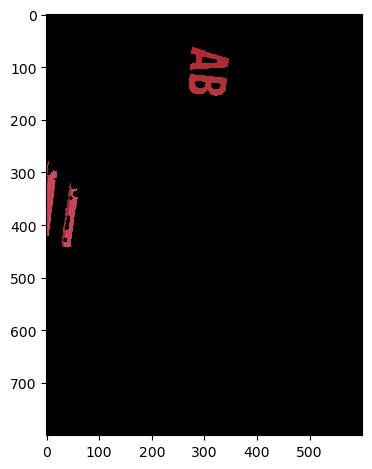

In [54]:

# Step 1: Create a binary image
binary_image = np.where((image[:, :, 0] > 100) & (image[:, :, 1] < 100) & (image[:, :, 2] < 100), 1, 0)

# Step 2: Erode the binary image
selem = disk(3)
eroded_image = morphology.binary_erosion(binary_image, selem)

# Step 3: Label all connected components (BLOBs)
label_image = measure.label(eroded_image)

# Step 4: Calculate the area and perimeter of each BLOB
regions = measure.regionprops(label_image)

# Step 5: Filter BLOBs based on area and perimeter conditions
filtered_regions = [region for region in regions if (1000 <= region.area <= 4000) and (region.perimeter >= 300)]

# Assuming you want to visualize the results:
output_image = np.zeros_like(image)
for region in filtered_regions:
    for coordinates in region.coords:
        output_image[coordinates[0], coordinates[1], :] = image[coordinates[0], coordinates[1], :]

# Display the result
io.imshow(output_image)
io.show()

17

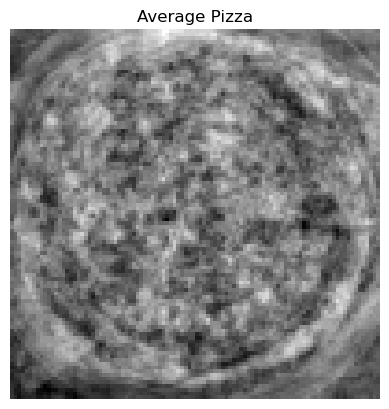

Explained variance ratio: [0.27451348 0.14492937 0.12480768 0.10678455 0.10101854]


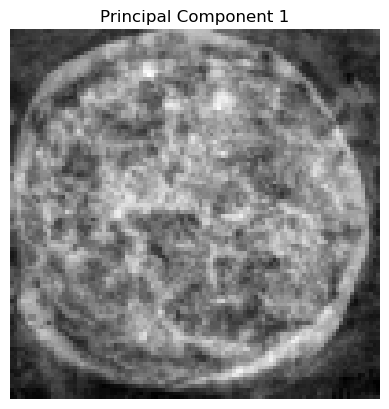

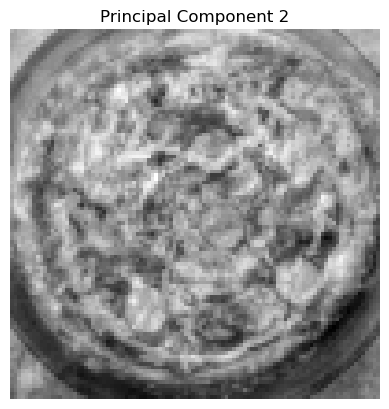

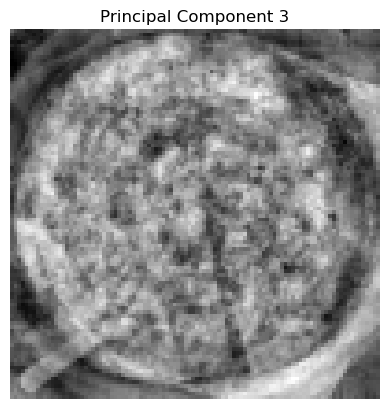

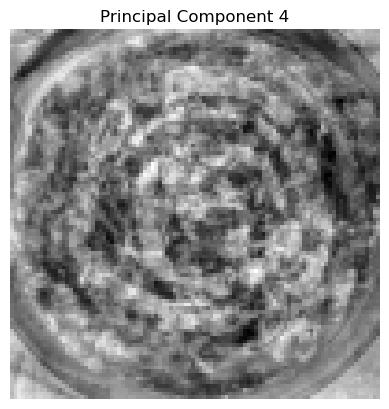

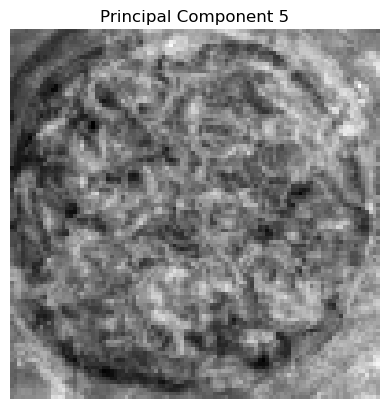

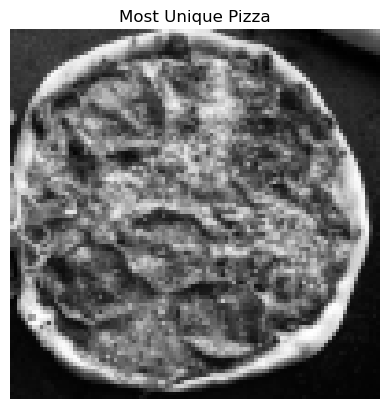

The pizza with the highest SSD (most unique visually) is at index 1 with an SSD of 716.7266078285045


In [55]:
def load_and_preprocess_images(folder_path, image_size=(100, 100)):
    image_files = glob.glob(folder_path + '/*.png')  # adjust the path and format as needed
    images = []
    for file in image_files:
        img = io.imread(file)
        img_gray = color.rgb2gray(img)  # convert to grayscale
        img_resized = resize(img_gray, image_size, anti_aliasing=True)  # resize images
        images.append(img_resized.flatten())  # flatten to 1D array

    return np.array(images)

def compute_average_image(images):
    return np.mean(images, axis=0)

def plot_image(data, image_size=(100, 100), title='Image'):
    plt.imshow(data.reshape(image_size), cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load images
folder_path = 'data/PizzaPCA/training'  # specify your path to the pizza images
images = load_and_preprocess_images(folder_path)

# Compute average pizza
average_pizza = compute_average_image(images)
plot_image(average_pizza, title='Average Pizza')

# PCA Analysis
pca = PCA(n_components=5)
pca.fit(images)
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Plot the principal components (Eigenpizzas)
for i in range(len(pca.components_)):
    plot_image(pca.components_[i], title=f'Principal Component {i+1}')

def sum_of_squared_differences(image1, image2):
    return np.sum((image1 - image2) ** 2)

# Compute SSDs between each pizza and the average pizza
ssds = np.array([sum_of_squared_differences(img, average_pizza) for img in images])

# Find the index of the pizza with the highest SSD
most_unique_pizza_index = np.argmax(ssds)
most_unique_pizza = images[most_unique_pizza_index]

# Plot the most unique pizza
plot_image(most_unique_pizza, title='Most Unique Pizza')

# Print out details
print(f"The pizza with the highest SSD (most unique visually) is at index {most_unique_pizza_index} with an SSD of {ssds[most_unique_pizza_index]}")

18

In [56]:
explained_variance_ratio = pca.explained_variance_ratio_

# Extract how much the first principal component explains of the total variation
first_component_explained_variance = explained_variance_ratio[0]

print(f"The first principal component explains {first_component_explained_variance * 100:.2f}% of the total variation.")

The first principal component explains 27.45% of the total variation.


19

In [57]:
# Project the images onto the PCA space
pca_scores = pca.transform(images)

# Find the index of the pizza with the maximum and minimum scores on the first principal axis
max_index = np.argmax(pca_scores[:, 0])  # Pizza with the highest score on PC1
min_index = np.argmin(pca_scores[:, 0])  # Pizza with the lowest score on PC1

print(f"The pizza for the positive signature is at index: {max_index}")
print(f"The pizza for the negative signature is at index: {min_index}")

The pizza for the positive signature is at index: 1
The pizza for the negative signature is at index: 3


20

In [59]:
# Load the new pizza image
super_pizza = io.imread('data/PizzaPCA/super_pizza.png')

super_pizza = color.rgb2gray(super_pizza)
  # convert to grayscale
image_size=(100, 100)
# Assuming all images need to be the same size as those used in training the PCA
super_pizza_resized = resize(super_pizza, image_size, anti_aliasing=True)  # Replace with actual dimensions used during training
super_pizza_flattened = super_pizza_resized.flatten()

# Project the new pizza onto the PCA space
super_pizza_pca = pca.transform([super_pizza_flattened])

# Assuming pca_scores contains the PCA projections of your menu pizzas
distances = np.linalg.norm(pca_scores - super_pizza_pca, axis=1)

# Find the closest pizza
closest_pizza_index = np.argmin(distances)
print(f"The most similar pizza to 'super_pizza.png' is at index: {closest_pizza_index}")

The most similar pizza to 'super_pizza.png' is at index: 4


21


In [61]:
# Load the image
image = io.imread('data/GeomTrans/lights.png')  # Update with the path to the image fileExams/Exam_Spring_2023/

# Rotate the image
image_rotated = rotate(image, angle=11, center=(40, 40), resize=False, mode='edge')

# Convert to grayscale
image_gray = color.rgb2gray(image_rotated)

# Apply Otsu's method to find the optimal threshold
threshold_value = threshold_otsu(image_gray)

# Create a binary image
image_binary = image_gray > threshold_value

# Calculate the percentage of foreground pixels
foreground_pixels = np.sum(image_binary)
total_pixels = image_binary.size
percentage_foreground = (foreground_pixels / total_pixels) * 100

print(f'The percentage of foreground pixels: {percentage_foreground:.2f}%')
print(f'Otsu\'s threshold value: {threshold_value}')

The percentage of foreground pixels: 25.62%
Otsu's threshold value: 0.42830429428086064
